In [10]:
import os
import re
import pandas as pd
import numpy as np
import struct
from datetime import datetime, timedelta
from pathlib import Path
from typing import List, Optional, Tuple
from dataclasses import dataclass

@dataclass
class TDFRampRecord:
    timestamp: datetime
    station_id: int
    ramp_controller: int
    ramp_rate: float
    ramp_start_freq: float
    transmitter_freq: float
    uplink_band: int
    spacecraft_id: int

class TDFParser:
    RECORD_SIZE = 288
    DATA_TYPE_RAMP = 6

    def __init__(self, verbose=True):
        self.verbose = verbose
        self.records = []

    def parse(self, filepath: str) -> pd.DataFrame:
        filepath = Path(filepath)
        if not filepath.exists():
            if self.verbose:
                print(f" Файл не найден: {filepath}")
            return pd.DataFrame()

        filesize = os.path.getsize(filepath)
        num_records = filesize // self.RECORD_SIZE

        if self.verbose:
            print(f"    TDF:  {filepath.name} ({num_records:,} records)")

        self.records = []
        with open(filepath, 'rb') as f:
            for _ in range(num_records):
                data = f.read(self.RECORD_SIZE)
                if len(data) < self.RECORD_SIZE:
                    break
                record = self._parse_record(data)
                if record:
                    self.records.append(record)

        if self.verbose:
            print(f"       RAMP записей:  {len(self.records)}")

        return self._to_dataframe()

    def _parse_record(self, data: bytes) -> Optional[TDFRampRecord]:
        record_type = struct.unpack('>I', data[5:9])[0]
        if record_type not in (90, 91):
            return None

        dtb1 = struct.unpack('>I', data[18:22])[0]
        data_type = (dtb1 >> 8) & 0x3F
        if data_type != self.DATA_TYPE_RAMP:
            return None

        timestamp = self._parse_datetime(data[9:18])
        if timestamp is None:
            return None

        station_id = (dtb1 >> 22) & 0x3FF
        spacecraft_id = struct.unpack('>H', data[22:24])[0]
        uplink_band = data[180]

        ramp_controller = data[225]
        ramp_rate_hp = struct.unpack('>i', data[226:230])[0]
        ramp_rate_lp = struct.unpack('>i', data[230:234])[0]
        ramp_rate = ramp_rate_hp * 1e3 + ramp_rate_lp * 1e-6

        val = int.from_bytes(data[234:239], 'big')
        ramp_start_hp = (val >> 4) & 0xFFFFFFFF
        val2 = int.from_bytes(data[238:243], 'big')
        ramp_start_lp = (val2 >> 4) & 0xFFFFFFFF
        ramp_start_freq = ramp_start_hp * 1e3 + ramp_start_lp * 1e-6

        change_block = data[243:252]
        val = int.from_bytes(change_block, 'big')
        tx_hp = (val >> 30) & 0x0FFFFFFF
        tx_lp = val & 0x3FFFFFFF
        transmitter_freq = tx_hp * 1e3 + tx_lp * 1e-6

        return TDFRampRecord(
            timestamp=timestamp,
            station_id=station_id,
            ramp_controller=ramp_controller,
            ramp_rate=ramp_rate,
            ramp_start_freq=ramp_start_freq,
            transmitter_freq=transmitter_freq,
            uplink_band=uplink_band,
            spacecraft_id=spacecraft_id,
        )

    def _parse_datetime(self, data: bytes) -> Optional[datetime]:
        val = int.from_bytes(data[0:7], 'big')
        year_mod = (val >> 44) & 0xFFF
        doy = (val >> 28) & 0xFFFF
        hour = (val >> 20) & 0xFF
        minute = (val >> 12) & 0xFF
        second = (val >> 4) & 0xFF

        year = 1900 + year_mod if year_mod >= 50 else 2000 + year_mod
        if doy == 0 or doy > 366:
            return None
        try:
            base_date = datetime(year, 1, 1)
            return base_date + timedelta(days=doy - 1, hours=hour, minutes=minute, seconds=second)
        except Exception:
            return None

    def _to_dataframe(self) -> pd.DataFrame:
        if not self.records:
            return pd.DataFrame()

        data = []
        for r in self.records:
            ctrl_name = {0: 'POCA', 1: 'DCO', 4: 'BlockV'}.get(r.ramp_controller, 'Unknown')
            data.append(
                {
                    'ramp_datetime_utc': r.timestamp,
                    'ramp_station_id': r.station_id,
                    'ramp_controller': r.ramp_controller,
                    'ramp_controller_name': ctrl_name,
                    'ramp_rate_hz_s': r.ramp_rate,
                    'ramp_start_freq_hz': r.ramp_start_freq,
                    'ramp_start_freq_ghz': r.ramp_start_freq / 1e9,
                    'uplink_band': r.uplink_band,
                    'spacecraft_id': r.spacecraft_id,
                }
            )
        return pd.DataFrame(data)

class MGSCombinedParser:
    def __init__(self, verbose=True):
        self.verbose = verbose
        self.epoch_1950 = datetime(1950, 1, 1, 0, 0, 0)
        self.doppler_data: Optional[pd.DataFrame] = None
        self.ramp_data: Optional[pd.DataFrame] = None

    def _clean_ramp_data(self, df: pd.DataFrame, max_ramp_rate: float = 20.0) -> pd.DataFrame:
        original = len(df)
        df_clean = df[abs(df['ramp_rate_hz_s']) <= max_ramp_rate].copy()
        removed = original - len(df_clean)
        if self.verbose and removed > 0:
            print(f"       Удалено аномалий: {removed} (|rate| > {max_ramp_rate} Hz/s)")
        return df_clean

    def parse_odf_folder(
        self,
        odf_folder: str,
        date_filter: Optional[Tuple[int, int]] = None,
        hour_start_first_day: Optional[int] = None,
        minute_start_first_hour: Optional[int] = None,
        parse_ramp_from_odf: bool = False,
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:
        folder = Path(odf_folder)
        lbl_files = sorted(list(folder.glob("*.lbl")) + list(folder.glob("*.LBL")))
        if not lbl_files:
            if self.verbose:
                print(" LBL файлы не найдены")
            return pd.DataFrame(), pd.DataFrame()

        all_doppler = []
        all_ramp_odf = []

        if self.verbose:
            print(f"\n{'='*60}")
            print(f" ПАРСИНГ ODF ФАЙЛОВ (DOPPLER/RAMP)")
            print(f"{'='*60}")
            print(f"   Найдено LBL файлов: {len(lbl_files)}")

        for lbl_file in lbl_files:
            tables = self._parse_lbl_file(lbl_file)
            for table_name, table_info in tables.items():
                odf_path = self._find_odf_file(odf_folder, table_info['odf_file'])
                if not odf_path:
                    continue

                # Доплер (ODF3C)
                if 'ODF3C' in table_name.upper():
                    df = self._parse_odf3c_table(
                        odf_path,
                        table_info['start_record'],
                        table_info.get('record_bytes', 36),
                        max_records=table_info.get('rows'),
                        date_filter=date_filter,
                        hour_start_first_day=hour_start_first_day,
                        minute_start_first_hour=minute_start_first_hour,
                    )
                    if not df.empty:
                        df['lbl_file'] = lbl_file.name
                        all_doppler.append(df)

                # РАМПЫ: группы ODF4Bxx
                # РАМПЫ: группы ODF4Bxx
                if parse_ramp_from_odf and table_name.upper().startswith("ODF4B"):
                    # вытаскиваем station_id из имени таблицы (ODF4B15 -> 15)
                    station_hint = None
                    m = re.search(r'ODF4B(\d+)', table_name.upper())
                    if m:
                        try:
                            station_hint = int(m.group(1))
                        except ValueError:
                            station_hint = None

                    df_ramp = self._parse_odf4b_ramp_table(
                        odf_path,
                        table_info['start_record'],
                        table_info.get('record_bytes', 36),
                        max_records=table_info.get('rows'),
                        date_filter=date_filter,
                        hour_start_first_day=hour_start_first_day,
                        minute_start_first_hour=minute_start_first_hour,
                        station_id_hint=station_hint,  # <-- передаем станцию из имени таблицы
                    )
                    if not df_ramp.empty:
                        df_ramp['lbl_file'] = lbl_file.name
                        all_ramp_odf.append(df_ramp)

                # (Опционально) старый прототип ODF3B/RAMP
                if parse_ramp_from_odf and ('ODF3B' in table_name.upper() or 'RAMP' in table_name.upper()):
                    df_ramp = self._parse_odf3b_ramp_table(
                        odf_path,
                        table_info['start_record'],
                        table_info.get('record_bytes', 36),
                        max_records=table_info.get('rows'),
                        date_filter=date_filter,
                        hour_start_first_day=hour_start_first_day,
                        minute_start_first_hour=minute_start_first_hour,
                    )
                    if not df_ramp.empty:
                        df_ramp['lbl_file'] = lbl_file.name
                        all_ramp_odf.append(df_ramp)

        if all_doppler:
            self.doppler_data = pd.concat(all_doppler, ignore_index=True)
            self.doppler_data = self.doppler_data.sort_values('datetime_utc').reset_index(drop=True)

        ramp_odf_df = pd.concat(all_ramp_odf, ignore_index=True) if all_ramp_odf else pd.DataFrame()
        if not ramp_odf_df.empty:
            ramp_odf_df = ramp_odf_df.drop_duplicates(
                subset=['ramp_datetime_utc','ramp_station_id','ramp_start_freq_hz','ramp_rate_hz_s']).sort_values('ramp_datetime_utc').reset_index(drop=True)
        return self.doppler_data if self.doppler_data is not None else pd.DataFrame(), ramp_odf_df

    def _parse_lbl_file(self, lbl_path: Path) -> dict:
        tables = {}
        try:
            with open(lbl_path, 'r', encoding='utf-8', errors='ignore') as f:
                content = f.read()

            pattern = r'^\^(\w+)\s*=\s*\(\s*"([^"]+)",\s*(\d+)\s*\)'
            matches = re.findall(pattern, content, re.MULTILINE)
            for table_name, odf_file, start_record in matches:
                rb_pattern = rf'{re.escape(table_name)}\.RECORD_BYTES\s*=\s*(\d+)'
                rb_match = re.search(rb_pattern, content)
                record_bytes = int(rb_match.group(1)) if rb_match else 36

                rows_pattern = rf'{re.escape(table_name)}\s*[\r\n\s]+ROWS\s*=\s*(\d+)'
                rows_match = re.search(rows_pattern, content, re.IGNORECASE)
                rows = int(rows_match.group(1)) if rows_match else None

                tables[table_name] = {
                    'odf_file': odf_file,
                    'start_record': int(start_record),
                    'record_bytes': record_bytes,
                    'rows': rows,
                }
            if self.verbose:
                print(f"    {lbl_path.name}:  {len(tables)} таблиц")
        except Exception as e:
            print(f"    Ошибка LBL {lbl_path.name}: {e}")
        return tables

    def _find_odf_file(self, folder_path: str, odf_filename: str) -> Optional[Path]:
        folder = Path(folder_path)
        for file in folder.iterdir():
            if file.name.upper() == odf_filename.upper():
                return file
        return None

    def _parse_odf3c_table(
        self,
        odf_path: Path,
        start_record: int,
        record_size: int = 36,
        max_records: int = None,
        date_filter: Optional[Tuple[int, int]] = None,
        hour_start_first_day: Optional[int] = None,
        minute_start_first_hour: Optional[int] = None,
    ) -> pd.DataFrame:
        records = []
        try:
            with open(odf_path, 'rb') as f:
                f.seek((start_record - 1) * record_size)
                while True:
                    if max_records and len(records) >= max_records:
                        break
                    chunk = f.read(record_size)
                    if not chunk or len(chunk) < record_size:
                        break
                    record = self._parse_odf3c_record(
                        chunk, date_filter, hour_start_first_day, minute_start_first_hour
                    )
                    if record:
                        record['source_file'] = odf_path.name
                        records.append(record)
            if self.verbose and records:
                print(f"       {odf_path.name}: {len(records)} записей")
        except Exception as e:
            print(f"       Ошибка {odf_path.name}: {e}")
        return pd.DataFrame(records)

    def _parse_odf3c_record(
        self,
        chunk: bytes,
        date_filter: Optional[Tuple[int, int]] = None,
        hour_start_first_day: Optional[int] = None,
        minute_start_first_hour: Optional[int] = None,
    ) -> Optional[dict]:
        if len(chunk) < 36:
            return None
        try:
            time_int = struct.unpack('>I', chunk[0:4])[0]
            time_frac = struct.unpack('>I', chunk[4:8])[0]
            obs_int = struct.unpack('>i', chunk[8:12])[0]
            obs_frac = struct.unpack('>I', chunk[12:16])[0]
            if time_int < 1_000_000:
                return None

            bits_value = struct.unpack('>I', chunk[16:20])[0]
            data_type_id = (bits_value >> 7) & 0x3F
            if data_type_id != 12:
                return None

            doppler_hz = obs_int + obs_frac / 2**32
            if abs(doppler_hz) > 100_000:
                return None

            total_seconds = time_int + time_frac / 2**32
            utc_time = self.epoch_1950 + timedelta(seconds=total_seconds)

            if date_filter:
                d0, d1 = date_filter
                if not (d0 <= utc_time.day <= d1):
                    return None
                if hour_start_first_day:
                    if utc_time.day == d0:
                        if utc_time.hour < hour_start_first_day:
                            return None
                        if utc_time.hour == hour_start_first_day and minute_start_first_hour:
                            if utc_time.minute < minute_start_first_hour:
                                return None

            # ref freq: Item 18 (word5) + Item 19 (word6), как в LBL
            ref_freq_mhz = 0.0
            if len(chunk) >= 28:
                word5 = struct.unpack('>I', chunk[20:24])[0]  # kHz
                word6 = struct.unpack('>I', chunk[24:28])[0]  # micro-Hz
                ref_freq_hz = word5 * 1e3 + word6 * 1e-6
                ref_freq_mhz = ref_freq_hz / 1e6

            compression_time = None
            if len(chunk) >= 32:
                compression_time_raw = struct.unpack('>I', chunk[28:32])[0]
                compression_time = float(compression_time_raw)

            return {
                'datetime_utc': utc_time,
                'time_tag_seconds': total_seconds,
                'doppler_hz': doppler_hz,
                'data_type_id': data_type_id,
                'receiving_station_id': (bits_value >> 22) & 0x7F,
                'transmitting_station_id': (bits_value >> 15) & 0x7F,
                'ref_freq_mhz': ref_freq_mhz,
                'compression_time': compression_time,
            }
        except Exception:
            return None

    def _parse_odf4b_ramp_table(
        self,
        odf_path: Path,
        start_record: int,
        record_size: int = 36,
        max_records: int = None,
        date_filter: Optional[Tuple[int, int]] = None,
        hour_start_first_day: Optional[int] = None,
        minute_start_first_hour: Optional[int] = None,
        station_id_hint: Optional[int] = None,   # <-- новый аргумент
    ) -> pd.DataFrame:
        records = []
        try:
            with open(odf_path, 'rb') as f:
                f.seek((start_record - 1) * record_size)
                while True:
                    if max_records and len(records) >= max_records:
                        break
                    chunk = f.read(record_size)
                    if not chunk or len(chunk) < record_size:
                        break
                    rec = self._parse_odf4b_ramp_record(
                        chunk,
                        date_filter=date_filter,
                        hour_start_first_day=hour_start_first_day,
                        minute_start_first_hour=minute_start_first_hour,
                        station_id_hint=station_id_hint,  # <-- проброс
                    )
                    if rec:
                        rec['source_file'] = odf_path.name
                        records.append(rec)
        except Exception as e:
            print(f"       Ошибка {odf_path.name}: {e}")
        return pd.DataFrame(records)

    def _parse_odf4b_ramp_record(
        self,
        chunk: bytes,
        date_filter: Optional[Tuple[int, int]] = None,
        hour_start_first_day: Optional[int] = None,
        minute_start_first_hour: Optional[int] = None,
        station_id_hint: Optional[int] = None,
    ) -> Optional[dict]:
        try:
            if len(chunk) < 36:
                return None
            t_int = struct.unpack('>I', chunk[0:4])[0]
            t_frac_ns = struct.unpack('>I', chunk[4:8])[0]
            total_seconds = t_int + t_frac_ns * 1e-9
            utc_time = self.epoch_1950 + timedelta(seconds=total_seconds)

            if date_filter:
                d0, d1 = date_filter
                if not (d0 <= utc_time.day <= d1):
                    return None
                if hour_start_first_day:
                    if utc_time.day == d0:
                        if utc_time.hour < hour_start_first_day:
                            return None
                        if utc_time.hour == hour_start_first_day and minute_start_first_hour:
                            if utc_time.minute < minute_start_first_hour:
                                return None

            rate_int  = struct.unpack('>i', chunk[8:12])[0]
            rate_frac = struct.unpack('>i', chunk[12:16])[0]
            ramp_rate = rate_int + rate_frac * 1e-9

            bits_5_6 = struct.unpack('>I', chunk[16:20])[0]
            ramp_start_ghz_int = bits_5_6 >> 10
            station_from_bits  = bits_5_6 & 0x3FF
            station_id = station_id_hint if station_id_hint is not None else station_from_bits

            # отбрасываем мусорные записи без GHz части
            if ramp_start_ghz_int <= 0:
                return None

            start_int  = struct.unpack('>I', chunk[20:24])[0]
            start_frac = struct.unpack('>I', chunk[24:28])[0]
            ramp_start_freq_hz = ramp_start_ghz_int * 1e9 + start_int + start_frac * 1e-9
            if ramp_start_freq_hz <= 0:
                return None

            ramp_start_freq_ghz_total = ramp_start_freq_hz / 1e9

            end_int = struct.unpack('>I', chunk[28:32])[0]
            end_frac_ns = struct.unpack('>I', chunk[32:36])[0]
            end_time = self.epoch_1950 + timedelta(seconds=end_int + end_frac_ns * 1e-9)

            return {
                'ramp_datetime_utc': utc_time,
                'ramp_end_datetime_utc': end_time,
                'time_tag_seconds': total_seconds,
                'ramp_rate_hz_s': ramp_rate,
                'ramp_start_freq_hz': ramp_start_freq_hz,
                'ramp_start_freq_ghz': ramp_start_freq_ghz_total,
                'ramp_start_ghz_int': ramp_start_ghz_int,
                'ramp_station_id': station_id,
            }
        except Exception:
            return None

    # Прототип для возможных ODF3B/других форматов
    def _parse_odf3b_ramp_table(
        self,
        odf_path: Path,
        start_record: int,
        record_size: int = 36,
        max_records: int = None,
        date_filter: Optional[Tuple[int, int]] = None,
        hour_start_first_day: Optional[int] = None,
        minute_start_first_hour: Optional[int] = None,
    ) -> pd.DataFrame:
        records = []
        try:
            with open(odf_path, 'rb') as f:
                f.seek((start_record - 1) * record_size)
                while True:
                    if max_records and len(records) >= max_records:
                        break
                    chunk = f.read(record_size)
                    if not chunk or len(chunk) < record_size:
                        break
                    rec = self._parse_odf3b_ramp_record(
                        chunk,
                        date_filter=date_filter,
                        hour_start_first_day=hour_start_first_day,
                        minute_start_first_hour=minute_start_first_hour,
                    )
                    if rec:
                        rec['source_file'] = odf_path.name
                        records.append(rec)
        except Exception as e:
            print(f"       Ошибка {odf_path.name}: {e}")
        return pd.DataFrame(records)

    def _parse_odf3b_ramp_record(
        self,
        chunk: bytes,
        date_filter: Optional[Tuple[int, int]] = None,
        hour_start_first_day: Optional[int] = None,
        minute_start_first_hour: Optional[int] = None,
    ) -> Optional[dict]:
        try:
            if len(chunk) < 36:
                return None

            time_int = struct.unpack('>I', chunk[0:4])[0]
            time_frac = struct.unpack('>I', chunk[4:8])[0]
            total_seconds = time_int + time_frac / 2**32
            utc_time = self.epoch_1950 + timedelta(seconds=total_seconds)

            if date_filter:
                day_start, day_end = date_filter
                if not (day_start <= utc_time.day <= day_end):
                    return None
                if hour_start_first_day:
                    if utc_time.day == date_filter[0]:
                        if utc_time.hour < hour_start_first_day:
                            return None
                        if utc_time.hour == hour_start_first_day and minute_start_first_hour:
                            if utc_time.minute < minute_start_first_hour:
                                return None

            bits_value = struct.unpack('>I', chunk[16:20])[0]
            data_type_id = (bits_value >> 7) & 0x3F
            if data_type_id not in (6, 90, 91, 12):
                return None

            receiving_station_id = (bits_value >> 22) & 0x7F
            transmitting_station_id = (bits_value >> 15) & 0x7F

            ramp_rate_hp = struct.unpack('>i', chunk[20:24])[0]
            ramp_rate_lp = struct.unpack('>i', chunk[24:28])[0]
            ramp_rate = ramp_rate_hp * 1e3 + ramp_rate_lp * 1e-6

            ramp_start_hp = struct.unpack('>i', chunk[28:32])[0]
            ramp_start_lp = struct.unpack('>i', chunk[32:36])[0]
            ramp_start_freq = ramp_start_hp * 1e3 + ramp_start_lp * 1e-6

            return {
                'ramp_datetime_utc': utc_time,
                'time_tag_seconds': total_seconds,
                'ramp_rate_hz_s': ramp_rate,
                'ramp_start_freq_hz': ramp_start_freq,
                'receiving_station_id': receiving_station_id,
                'transmitting_station_id': transmitting_station_id,
            }
        except Exception:
            return None

    def parse_all(
        self,
        odf_folder: str,
        tdf_folder: str = None,
        date_filter: Optional[Tuple[int, int]] = None,
        hour_start_first_day: Optional[int] = None,
        minute_start_first_hour: Optional[int] = None,
        output_file: str = None,
        ramp_output_file: str = None,
        parse_ramp_from_odf: bool = False,
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:
        # TDF временно отключены по просьбе: не парсим и не сохраняем
        print("\n" + "=" * 70)
        print(" MGS COMBINED PARSER:  ODF + LBL")
        print("=" * 70)

        doppler_df, ramp_odf_df = self.parse_odf_folder(
            odf_folder,
            date_filter,
            hour_start_first_day,
            minute_start_first_hour,
            parse_ramp_from_odf=parse_ramp_from_odf,
        )

        if output_file and doppler_df is not None and not doppler_df.empty:
            doppler_df.to_csv(output_file, index=False)
            print(f"\n Сохранено:  {output_file}")

        print("\n" + "=" * 70)
        print(" ПАРСИНГ ЗАВЕРШЁН")
        print("=" * 70)
        return doppler_df, ramp_odf_df

print("MGSCombinedParser загружен!")

MGSCombinedParser загружен!


Запуск парсинга и проверка данных

In [ ]:
import os

parser = MGSCombinedParser(verbose=True)

ODF_FOLDER = "input_data"        # ODF и LBL файлы
TDF_FOLDER = "input_data"        # TDF файлы (можно ту же папку)
OUTPUT_FILE = "output_data/mgs_doppler.csv"
RAMP_FILE = "output_data/mgs_ramp.csv"

if not os.path.exists("output_data"):
    os.makedirs("output_data")

parser = MGSCombinedParser(verbose=True)
doppler_df, ramp_odf_df = parser.parse_all(
    odf_folder="input_data",
    date_filter=(19, 20),
    hour_start_first_day=4,
    minute_start_first_hour=0,
    output_file="output_data/mgs_doppler.csv",
    parse_ramp_from_odf=True,
)

# Сохраняем рампы из ODF
if ramp_odf_df is not None and not ramp_odf_df.empty:
    ramp_odf_df.to_csv("output_data/mgs_ramp.csv", index=False)
    print(" RAMP из ODF сохранены в output_data/mgs_ramp.csv")

print(f"\nИтоговый DataFrame (doppler):  {len(doppler_df)} записей")
print(f"Итоговый DataFrame (ramp):     {len(ramp_odf_df) if ramp_odf_df is not None else 0} записей")

if len(doppler_df) > 0:
    print("\nПо станциям:")
    print(doppler_df.groupby('receiving_station_id').agg({
        'doppler_hz': ['count', 'mean', 'std'],
    }).round(3))

    print(f"\nПериод Doppler: {doppler_df['datetime_utc'].min()} — {doppler_df['datetime_utc'].max()}")
if ramp_odf_df is not None and len(ramp_odf_df) > 0:
    print(f"Период RAMP:     {ramp_odf_df['ramp_datetime_utc'].min()} — {ramp_odf_df['ramp_datetime_utc'].max()}")


 MGS COMBINED PARSER:  ODF + LBL

 ПАРСИНГ ODF ФАЙЛОВ (DOPPLER/RAMP)
   Найдено LBL файлов: 11
    7258260a.lbl:  4 таблиц
    7260261a.lbl:  4 таблиц
    7261262a.lbl:  18 таблиц
       7261262a.odf: 144 записей
    7262262a.lbl:  16 таблиц
       7262262a.odf: 311 записей
    7262262b.lbl:  16 таблиц
       7262262b.odf: 120 записей
    7262262c.lbl:  14 таблиц
       7262262c.odf: 139 записей
    7262263a.lbl:  14 таблиц
       7262263a.odf: 282 записей
    7263263a.lbl:  16 таблиц
       7263263a.odf: 620 записей
    7263263b.lbl:  14 таблиц
       7263263b.odf: 119 записей
    7263263c.lbl:  14 таблиц
       7263263c.odf: 244 записей
    7263265a.lbl:  4 таблиц

 Сохранено:  output_data/mgs_doppler.csv

 ПАРСИНГ ЗАВЕРШЁН
 RAMP из ODF сохранены в output_data/mgs_ramp.csv

Итоговый DataFrame (doppler):  1979 записей
Итоговый DataFrame (ramp):     280 записей

По станциям:
                     doppler_hz                     
                          count       mean       std
recei

Визуализация

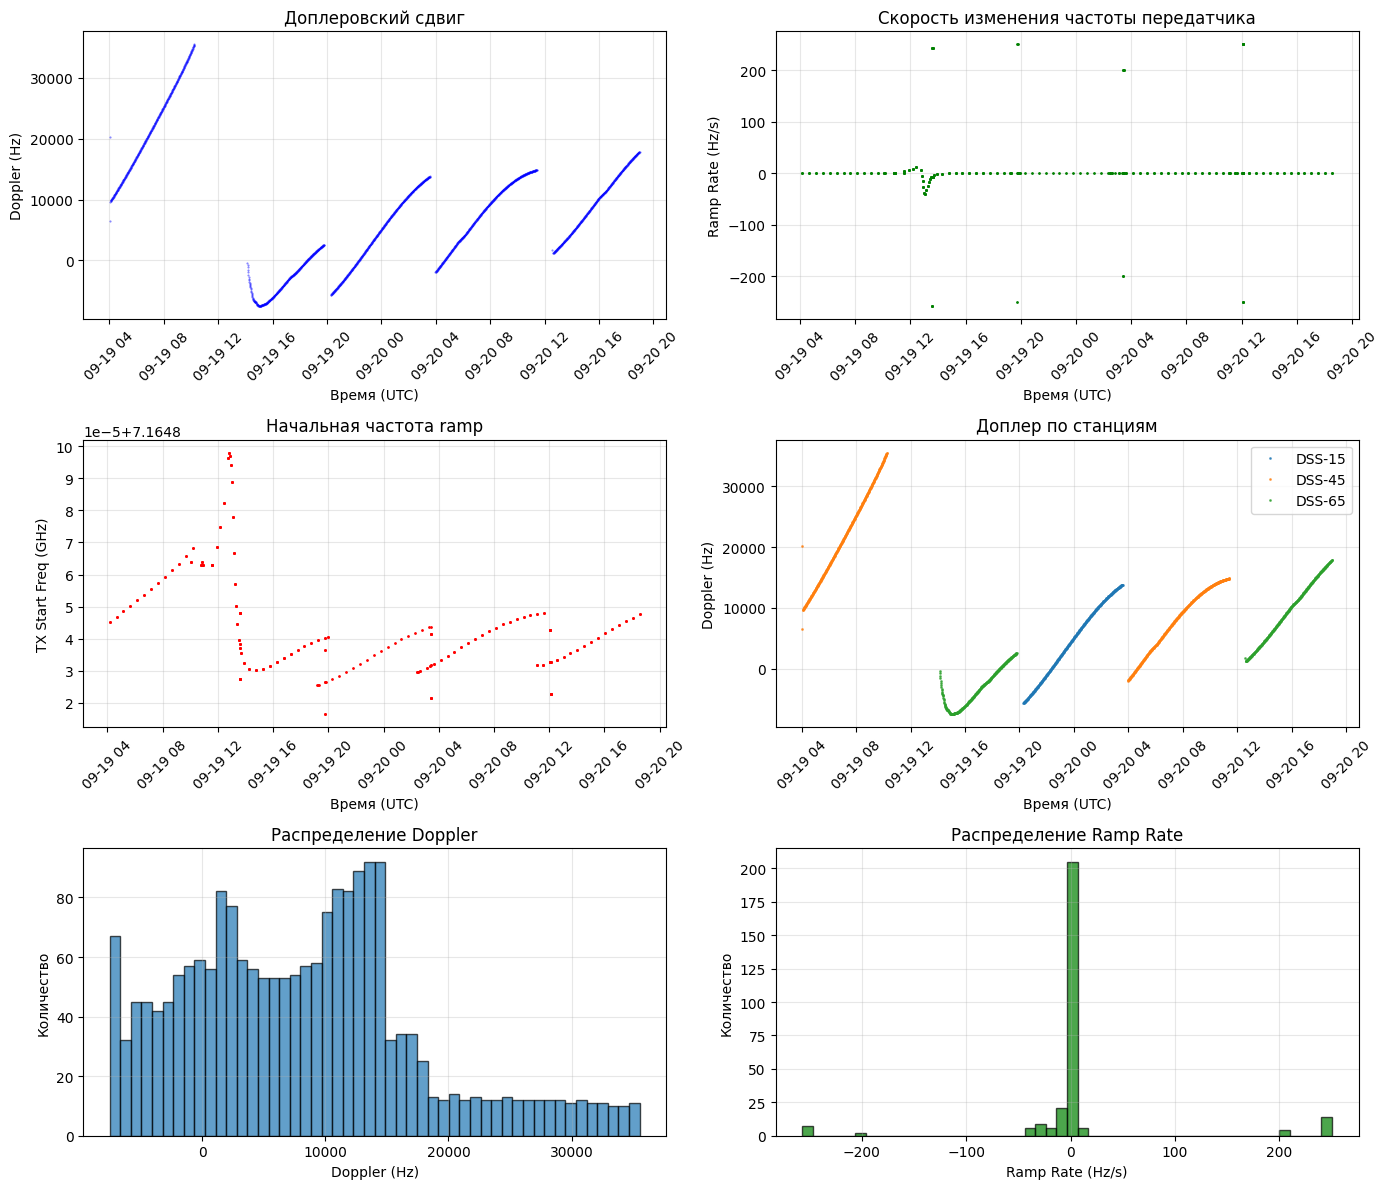

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Загружаем выходные таблицы ---
doppler_df = pd.read_csv('output_data/mgs_doppler.csv', parse_dates=['datetime_utc'])
ramp_df = pd.read_csv('output_data/mgs_ramp.csv', parse_dates=['ramp_datetime_utc'])

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# 1. Доплер во времени
ax = axes[0, 0]
ax.plot(doppler_df['datetime_utc'], doppler_df['doppler_hz'],
        'b.', markersize=1, alpha=0.5)
ax.set_xlabel('Время (UTC)')
ax.set_ylabel('Doppler (Hz)')
ax.set_title('Доплеровский сдвиг')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

# 2. Ramp Rate во времени (теперь из ramp_df)
ax = axes[0, 1]
ax.plot(ramp_df['ramp_datetime_utc'], ramp_df['ramp_rate_hz_s'],
        'g.', markersize=2)
ax.set_xlabel('Время (UTC)')
ax.set_ylabel('Ramp Rate (Hz/s)')
ax.set_title('Скорость изменения частоты передатчика')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

# 3. Абсолютная ramp-частота по времени (ramp_df)
ax = axes[1, 0]
ax.plot(ramp_df['ramp_datetime_utc'], ramp_df['ramp_start_freq_hz'] / 1e9,
        'r.', markersize=2)
ax.set_xlabel('Время (UTC)')
ax.set_ylabel('TX Start Freq (GHz)')
ax.set_title('Начальная частота ramp')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

# 4. Доплер по станциям
ax = axes[1, 1]
for station in sorted(doppler_df['receiving_station_id'].unique()):
    mask = doppler_df['receiving_station_id'] == station
    ax.plot(doppler_df.loc[mask, 'datetime_utc'],
            doppler_df.loc[mask, 'doppler_hz'],
            '.', markersize=2, label=f'DSS-{station}', alpha=0.7)
ax.set_xlabel('Время (UTC)')
ax.set_ylabel('Doppler (Hz)')
ax.set_title('Доплер по станциям')
ax.tick_params(axis='x', rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Гистограмма Doppler
ax = axes[2, 0]
ax.hist(doppler_df['doppler_hz'], bins=50, edgecolor='black', alpha=0.7)
ax.set_xlabel('Doppler (Hz)')
ax.set_ylabel('Количество')
ax.set_title('Распределение Doppler')
ax.grid(True, alpha=0.3)

# 6. Гистограмма Ramp Rate (по ramp_df)
ax = axes[2, 1]
ax.hist(ramp_df['ramp_rate_hz_s'], bins=50, edgecolor='black', alpha=0.7, color='green')
ax.set_xlabel('Ramp Rate (Hz/s)')
ax.set_ylabel('Количество')
ax.set_title('Распределение Ramp Rate')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('output_data/combined_analysis.png', dpi=150)
plt.show()

Очистка данных

 ОЧИСТКА DOPPLER

 Итог: 1979 → 1972 записей (99.6%)
       5 сеансов
 ОЧИСТКА RAMP

 Итог: 280 → 232 (|ramp_rate| <= 15.0) (82.9%)
   Станций: 3


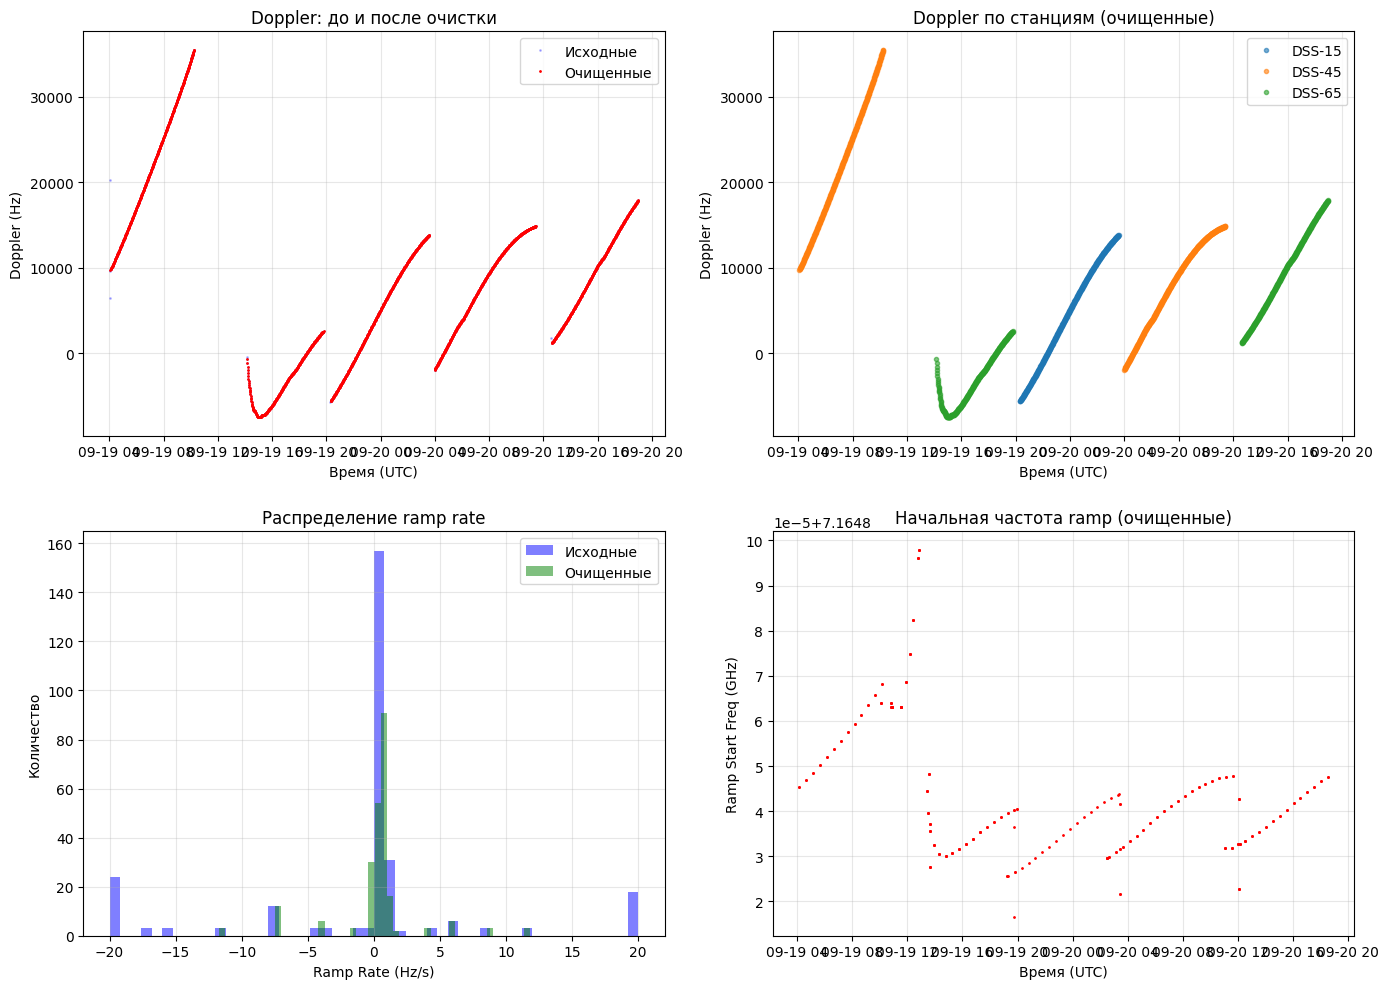

In [13]:
import pandas as pd
import numpy as np
from datetime import timedelta

def clean_doppler_df(df,
                     max_jump_hz=1000,
                     max_doppler_rate=15.0,
                     max_gap_min=5):
    """
    Очищает только доплеровский DataFrame.
    """
    print("="*60)
    print(" ОЧИСТКА DOPPLER")
    print("="*60)
    df_work = df.sort_values('datetime_utc').copy()
    original_count = len(df_work)
    # Технические колонки
    df_work['time_diff_sec'] = df_work['datetime_utc'].diff().dt.total_seconds()
    df_work['doppler_diff'] = df_work['doppler_hz'].diff()
    df_work['doppler_rate'] = df_work['doppler_diff'] / df_work['time_diff_sec']
    # Фильтр скачков
    mask_no_jumps = abs(df_work['doppler_diff']) <= max_jump_hz
    mask_no_jumps = mask_no_jumps.fillna(True)
    # Фильтр по скорости изменения
    mask_good_doppler_rate = abs(df_work['doppler_rate']) <= max_doppler_rate
    mask_good_doppler_rate = mask_good_doppler_rate.fillna(True)
    # Общий фильтр
    final_mask = mask_no_jumps & mask_good_doppler_rate
    df_clean = df_work[final_mask].copy()
    # Сеансы
    df_clean['time_diff_sec'] = df_clean['datetime_utc'].diff().dt.total_seconds()
    time_gaps = df_clean['time_diff_sec'] > (max_gap_min * 60)
    df_clean['session_id'] = time_gaps.cumsum()
    print(f"\n Итог: {original_count} → {len(df_clean)} записей ({100*len(df_clean)/original_count:.1f}%)")
    print(f"       {df_clean['session_id'].nunique()} сеансов")
    df_clean.drop(columns=['time_diff_sec','doppler_diff','doppler_rate'], errors='ignore', inplace=True)
    return df_clean

def clean_ramp_df(df, max_ramp_rate=15.0):
    """
    Очищает только ramp-DataFrame.
    """
    print("="*60)
    print(" ОЧИСТКА RAMP")
    print("="*60)
    df_work = df.sort_values('ramp_datetime_utc').copy()
    original_count = len(df_work)
    mask_good_ramp = df_work['ramp_rate_hz_s'].abs() <= max_ramp_rate
    mask_good_ramp = mask_good_ramp.fillna(False)
    df_clean = df_work[mask_good_ramp].copy()
    print(f"\n Итог: {original_count} → {len(df_clean)} (|ramp_rate| <= {max_ramp_rate}) ({100*len(df_clean)/original_count:.1f}%)")
    print(f"   Станций: {df_clean['ramp_station_id'].nunique()}")
    return df_clean

import matplotlib.pyplot as plt

def plot_cleaning_results_separated(orig_dopp, clean_dopp, orig_ramp, clean_ramp):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Доплер до/после
    ax = axes[0, 0]
    ax.plot(orig_dopp['datetime_utc'], orig_dopp['doppler_hz'], 'b.', alpha=0.25, ms=2, label='Исходные')
    ax.plot(clean_dopp['datetime_utc'], clean_dopp['doppler_hz'], 'r.', ms=2, label='Очищенные')
    ax.set_title('Doppler: до и после очистки')
    ax.set_xlabel('Время (UTC)')
    ax.set_ylabel('Doppler (Hz)')
    ax.legend()
    ax.grid(alpha=0.3)

    # 2. По станциям (только очищенные)
    ax = axes[0, 1]
    for station in sorted(clean_dopp['receiving_station_id'].unique()):
        sel = clean_dopp['receiving_station_id'] == station
        ax.plot(clean_dopp.loc[sel, 'datetime_utc'],
                clean_dopp.loc[sel, 'doppler_hz'], '.',
                label=f'DSS-{station}', alpha=0.6)
    ax.set_title('Doppler по станциям (очищенные)')
    ax.set_xlabel('Время (UTC)')
    ax.set_ylabel('Doppler (Hz)')
    ax.legend()
    ax.grid(alpha=0.3)

    # 3. Ramp Rate до/после
    ax = axes[1, 0]
    ax.hist(orig_ramp['ramp_rate_hz_s'].clip(-20, 20), bins=50, color='blue', alpha=0.5, label='Исходные')
    ax.hist(clean_ramp['ramp_rate_hz_s'].clip(-20, 20), bins=50, color='green', alpha=0.5, label='Очищенные')
    ax.set_title('Распределение ramp rate')
    ax.set_xlabel('Ramp Rate (Hz/s)')
    ax.set_ylabel('Количество')
    ax.legend()
    ax.grid(alpha=0.3)

    # 4. Начальная частота ramp (очищенные)
    ax = axes[1, 1]
    ax.plot(clean_ramp['ramp_datetime_utc'],
            clean_ramp['ramp_start_freq_hz']/1e9, 'r.', ms=2)
    ax.set_title('Начальная частота ramp (очищенные)')
    ax.set_xlabel('Время (UTC)')
    ax.set_ylabel('Ramp Start Freq (GHz)')
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('output_data/cleaning_report_separated.png', dpi=150)
    plt.show()

doppler_df = pd.read_csv('output_data/mgs_doppler.csv', parse_dates=['datetime_utc'])
ramp_df = pd.read_csv('output_data/mgs_ramp.csv', parse_dates=['ramp_datetime_utc'])

cleaned_doppler = clean_doppler_df(doppler_df)
cleaned_ramp = clean_ramp_df(ramp_df)

plot_cleaning_results_separated(doppler_df, cleaned_doppler, ramp_df, cleaned_ramp)
cleaned_doppler.to_csv('output_data/mgs_doppler_CLEANED.csv', index=False)
cleaned_ramp.to_csv('output_data/mgs_ramp_CLEANED.csv', index=False)